# Step 1: Pre-process images over the glaciers

_Last modified 2022-07-01._

This script processes downloaded images prior to the Wavelet Transform Modulus Maxima (WTMM) segmentation analysis that produces the calving front delineations. The images will be:

     1) Grab image acquisition dates from the images
     2) Reproject all downloaded images
     3) Calculate terminus box dimensions and rasterize
     4) Rotate using weighted average glacier flow direction
     5) Crop rotated images to the same minimum dimensions and convert to pgm format

### The rotation step (4) requires an input ice velocity raster (vx and vy files).

For Greenland, we use the [MEASURES 2000-2015](https://nsidc.org/data/NSIDC-0670/versions/1) ice velocity mosaic.

### The image conversion step (5) requires the installation of ImageMagick.

Download [ImageMagick](https://imagemagick.org/script/download.php) command line software.

In [1]:
import numpy as np
import pandas as pd
import os
import subprocess
import shutil
import rasterio as rio
from shapely import geometry
import fiona
import fiona.crs
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

from automated_terminus_functions import resize_pngs, distance

/Users/jukesliu/micromamba/envs/autoterm/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_92566/1057920446.py:13: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [4]:
#####################################################################################
# Enter folder containing the terminus box and RGI glacier outline shapefile(s):
basepath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/' 
downloadpath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/LSaws/' # folder containing downloaded Landsat images
csvpath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/' # folder to store CSV files
# that describes the analysis (e.g., glacier or group of glaciers) 
folder_name = 'rotated_c2' # foldername to hold rotated collection 2 images
csvext = '_testimages.csv' # same as in image download script, a file suffix

# Input your velocity input file info
vpath = basepath # path to folder containing velocity files
vx_name = 'greenland_vel_mosaic250_vx_v1.tif' # MEaSUREs product
vy_name = 'greenland_vel_mosaic250_vy_v1.tif' # MEaSUREs product
no_data_val = -2000000000.0 # no data value for the velocity maps
vt = 'day' # time unit for velocity (e.g., day for m/day, year for m/year)

# optional:
RGIpath = '/Volumes/SGlacier/auto-terminus-traces/Antarctic-test/ROIs/'  # path to folder with all individual RGI glacier outline shapefiles

# Enter glacier IDs

BoxIDs = ['Thwaites']
# boxes = list(map(str, np.arange(1, 51, 1))) #1, 642, 1 lists the full inventory
# for BoxID in boxes: # convert integers to 3-digit strings with leading zeros
#     BoxID = BoxID.zfill(3)
#     BoxIDs.append(BoxID)
# or read from a file
print(BoxIDs) # show the final BoxIDs
#####################################################################################

['Thwaites']


In [3]:
# filenames that will be written in this script
# all with common extension
print("CSV files that will be produced:"); print()
VEL_FILENAME = 'Glacier_vel'+csvext; print(VEL_FILENAME)
BOX_FILENAME = 'Buffdist'+csvext; print(BOX_FILENAME)
DATES_FILENAME = 'imgdates'+csvext; print(DATES_FILENAME) # acquisition dates for all downloaded Landsat images

CSV files that will be produced:

Glacier_vel_testimages.csv
Buffdist_testimages.csv
imgdates_testimages.csv


In [4]:
# create new BoxID folders if they don't already exist
for BoxID in BoxIDs:
    # create folder to hold glacier shapefiles
    shapefilepath = basepath+'Box'+BoxID+'/' # path to that folder
    if os.path.exists(shapefilepath):
#         shutil.rmtree(shapefilepath) # remove the old folder
        print("Path exists already for Box", BoxID)
    else:
        os.mkdir(basepath+'Box'+BoxID)
            
    # create folder to hold glacier images (inside downloadpath)
    if os.path.exists(downloadpath+'Box'+BoxID):
        print("Path exists already in LS8aws for Box", BoxID)
    else:
        os.mkdir(downloadpath+'Box'+BoxID)
    
    # Now place terminus box shapefile and RGI glacier outline shapefile into the
    # boxespath folder. Done automatically below for the Greenland peripheral glaciers:
    if len(BoxID) == 3:
        ID = int(BoxID) # make into an integer in order to grab the .shp files

        # if the terminus box shapefile is not in this folder, then move it
        if not os.path.exists(shapefilepath+'Box'+BoxID+'.shp'):
            for filename in os.listdir(boxespath):
                if filename.startswith('BoxID_'+str(ID)):
                    shutil.copyfile(boxespath+filename, basepath+'Box'+BoxID+'/Box'+BoxID+filename[-4:])
                    print("Box"+BoxID+filename[-4:], "moved")
        else:
            print("Box"+BoxID+'.shp', "already in folder")

        if not os.path.exists(shapefilepath+'RGI_Box'+BoxID+'.shp'): # if the RGI shapefile is not in this folder
            # move RGI glacier outline into the new folder
            for filename in os.listdir(RGIpath):
                if filename.startswith('BoxID_'+str(ID)):
                    shutil.copyfile(RGIpath+filename, basepath+'Box'+BoxID+'/RGI_Box'+BoxID+filename[-4:])
                    print("RGI_Box"+BoxID+filename[-4:], "moved")
        else:
            print("RGI_Box"+BoxID+'.shp', "already in folder")

Path exists already for Box 001
Path exists already in LS8aws for Box 001
Box001.shp already in folder
RGI_Box001.shp already in folder
Path exists already for Box 002
Path exists already in LS8aws for Box 002
Box002.shp already in folder
RGI_Box002.shp already in folder
Path exists already for Box 003
Path exists already in LS8aws for Box 003
Box003.shp already in folder
RGI_Box003.shp already in folder
Path exists already for Box 004
Path exists already in LS8aws for Box 004
Box004.shp already in folder
RGI_Box004.shp already in folder
Path exists already for Box 005
Path exists already in LS8aws for Box 005
Box005.shp already in folder
RGI_Box005.shp already in folder
Path exists already for Box 006
Path exists already in LS8aws for Box 006
Box006.shp already in folder
RGI_Box006.shp already in folder
Path exists already for Box 007
Path exists already in LS8aws for Box 007
Box007.shp already in folder
RGI_Box007.shp already in folder
Path exists already for Box 008
Path exists alre

# 1) Grab image acquisition dates from downloaded images

In [4]:
# If the acquisition date datafile wasn't already created in the downloading step,
if not os.path.exists(csvpath+DATES_FILENAME): 
    # create it now
    datetimes = []; scenenames = []
    for BoxID in BoxIDs:
        for img in os.listdir(downloadpath+'Box'+BoxID+'/'):
            if img.startswith('L') and img.endswith('TIF'):
                datestr = img[17:25] # grab acquisition date from filename
                date = datetime.datetime.strptime(datestr, '%Y%m%d') # save as datetime object
                datetimes.append(date); scenenames.append(img[:40])
    dates_df = pd.DataFrame(list(zip(scenenames, datetimes)),columns=['Scene','datetime'])        
    # write to csv
    dates_df.to_csv(path_or_buf = basepath+DATES_FILENAME, sep=',')  
    
else: # if it exists already, don't overwrite
    print('Already created in the download step:')
    dates_df = pd.read_csv(csvpath+DATES_FILENAME)
dates_df.head()

Already created in the download step:


,Unnamed: 0,Scene,datetime
0,0,LC08_L1TP_031005_20170603_20201016_02_T1,2017-06-03
1,1,LC08_L1TP_031005_20140915_20200911_02_T1,2014-09-15
2,2,LE07_L1TP_035005_20020614_20200916_02_T1,2002-06-14
3,3,LC08_L1TP_036004_20170318_20200904_02_T1,2017-03-18
4,4,LC08_L1TP_035005_20140522_20200911_02_T1,2014-05-22


# 2) Reproject the images

When images are downloaded across many different Landsat path rows, it's possible that they will be in several UTM projections. As a result, you will need to reproject them into a single projection (e.g., Greenland Polar Stereographic). 

#### If all your images are in the same projection, then you can skip this step. Change SKIP to True.

In [5]:
######################################################################################
SKIP = False # if you want to skip this step, change to True
desired_proj = '3413' # EPSG code for desired projection
suffix = '_PS' # suffix for reprojected images - something that indicates the projection
######################################################################################

for BoxID in BoxIDs:
    bp_out = downloadpath+'Box'+BoxID+'/' # path to downloaded files

    # create output reprojected folder if does not exist
    if os.path.exists(bp_out+'reprojected/'):
        print("Box"+BoxID, "Reprojected folder exists already.")
    else:
        os.mkdir(bp_out+'reprojected/')
        print("Box"+BoxID+" Reprojected directory made")
    
    for image in os.listdir(bp_out): # all downloaded images
        if image.startswith('L') and image.endswith('.TIF'):
            
            # if reprojection skipped, just move the image into the reprojected fodler
            if SKIP:
                shutil.copyfile(bp_out+image, bp_out+'reprojected/'+image)
            
            # if not skipped, reproject it
            else:
                imagename = image[:-4] # remove suffix
                rp_PS = "gdalwarp -t_srs EPSG:"+desired_proj+' '+bp_out+image+" "
                rp_PS += bp_out+'reprojected/'+imagename+suffix+".TIF"
                subprocess.run(rp_PS, shell=True,check=True)   

Box001 Reprojected folder exists already.


KeyboardInterrupt: 

# 3) Calculate terminus box dimensions and rasterize 
In this section, the minimum dimension of the terminus box is calculated which will be used in the generation of glacier flowlines in the analyze_wtmm_results.ipynb script.

In [6]:
# Calculate the minimum dimensions of the terminus boxes
mindimensions = [] # initialize empty list
for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/'):
        if 'UTM' in file and '.shp' in file and "Box" in file: # identify UTM projected box
            boxpath = basepath+"Box"+BoxID+"/"+file  
            termbox = fiona.open(boxpath)
    
    # automatically calculate spatial resolution of images and grab the extent
    for img in os.listdir(downloadpath+'Box'+BoxID+'/'):
        if img.startswith('L') and img.endswith('TIF'):
            img_reader = rio.open(downloadpath+'Box'+BoxID+'/'+img)
            PIXRES = img_reader.transform[0]
            print('Image spatial resolution of',PIXRES,' meters calculated from ',img)
            break # stop after the first image
            
    # grab the box coordinates:
    box = termbox.next(); box_geom= box.get('geometry'); box_coords = box_geom.get('coordinates')[0]
    points = []
    for coord_pair in box_coords:
        lat = coord_pair[0]; lon = coord_pair[1]; points.append([lat, lon])
            
    # Calculate distance between coord 1 and 2 and between 2 and 3
    coord1 = points[0]; coord2 = points[1]; coord3 = points[2]   
    dist1 = distance(coord1[0], coord1[1], coord2[0], coord2[1]);
    dist2 = distance(coord2[0], coord2[1], coord3[0], coord3[1]) 
    mindim = int(np.min([dist1, dist2]))/PIXRES # calculate minimum dimensions, converted into pixels
    mindimensions.append(int(mindim))

# if os.path.exists(csvpath+BOX_FILENAME): # if the buffer distance was calculated in the previous step
#     buff_df = pd.read_csv(csvpath+BOX_FILENAME, dtype=str)
#     buff_df['min_dim_px'] = mindimensions # add the minimum dimensions to the existing data
# else: # if not, create a new data file
buff_df = pd.DataFrame(list(zip(BoxIDs, mindimensions)), columns=['BoxID','min_dim_px'])
buff_df    

Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_031005_20170603_20201016_02_T1_B8_Buffer001.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_032005_20160420_20200907_02_T1_B8_Buffer002.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_032005_20190702_20200829_02_T1_B8_Buffer003.TIF


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_030005_20180802_20200831_02_T1_B8_Buffer004.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_032005_20150402_20200909_02_T1_B8_Buffer005.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_031006_20190422_20200828_02_T1_B8_Buffer006.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_031006_20150427_20200909_02_T1_B8_Buffer007.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_030006_20150810_20200908_02_T1_B8_Buffer008.TIF
Image spatial resolution of 15.0  meters calculated from  LE07_L1TP_028006_20030413_20200915_02_T1_B8_Buffer009.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_028006_20170817_20200903_02_T1_B8_Buffer010.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_029006_20140613_20200911_02_T1_B8_Buffer011.TIF
Image spatial resolution of 15.0  meters calculated from  LC08_L1TP_0280

,BoxID,min_dim_px
0,001,41
1,002,155
2,003,229
3,004,211
4,005,315
5,006,112
6,007,237
7,008,298
8,009,185
9,010,103


In [7]:
# write to csv
buff_df.to_csv(basepath+BOX_FILENAME) 

Then, the terminus boxes are rasterized using the **gdal_rasterize** command with the following syntax:

    gdal_rasterize -burn 1.0 -tr x_resolution y_resolution -a_nodata 0.0 path_to_terminusbox.shp path_to_terminusbox_raster.TIF

and subset to the image dimensions using **gdal_warp**:

    gdalwarp -cutline path_to_Buffer###.shp -crop_to_cutline path_to_terminusbox_raster.TIF path_to_subset_raster_cut.TIF

These rasterized terminus boxes will be used as a mask during the 2D WTMM analysis.     

In [8]:
# Rasterize images
for index, row in buff_df.iterrows():
    BoxID = row['BoxID']
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID # path to box
    buffer_path = basepath+"Box"+BoxID+"/Buffer"+BoxID # path to buffer
    
    terminusraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+".TIF" # path to rasterized box
    cutraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+"_raster_cut.TIF" # name for cropped file
    
    # Set rasterization command:
    rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr '+str(PIXRES)+' '+str(PIXRES) # PIXRES from image
    rasterize_cmd += ' -a_nodata 0.0 -ot Int16 '+terminusbox_path+'.shp '+terminusraster_path
    print("Rasterize:", rasterize_cmd); print()
    
    # Set subsetting command:
    if True:
#     if not os.path.exists(buffer_path+'.shp'): # if there is a buffer shapefile
        subsetpath = buffer_path # use it to subset the rasterized terminus box
#     else: # otherwise, use bounds from downloaded image
#         with fiona.open(terminusbox_path+'.shp', "r") as source: # grab EPSG of terminus box
#             source_crs = source.crs['init'].split(':')[1]
#         rp_path = downloadpath+'Box'+BoxID+'/reprojected/' # path to the reprojected images
#         ref_img = rio.open(rp_path+os.listdir(rp_path)[0]) # grab the first image
#         img_bounds = geometry.Polygon([geometry.Point(ref_img.bounds.left, ref_img.bounds.top),
#                     geometry.Point(ref_img.bounds.right, ref_img.bounds.top),
#                     geometry.Point(ref_img.bounds.right, ref_img.bounds.bottom),
#                     geometry.Point(ref_img.bounds.left, ref_img.bounds.bottom),
#                     geometry.Point(ref_img.bounds.left, ref_img.bounds.top)])
#         # Define a polygon feature geometry with one attribute
#         schema = {'geometry': 'Polygon','properties': {'id': 'int'}}
#         # Write a new Shapefile
#         with fiona.open(basepath+"Box"+BoxID+'/img_bounds_Box'+BoxID+'.shp', 'w', 'ESRI Shapefile', schema,
#                         crs=fiona.crs.from_epsg(source_crs))as c:
#             ## If there are multiple geometries, put the "for" loop here
#             c.write({'geometry': geometry.mapping(img_bounds),'properties': {'id': 123},})
#         subsetpath = basepath+"Box"+BoxID+'/img_bounds_Box'+BoxID # use this path
        
    subset_cmd = 'gdalwarp -overwrite -ot Int16 -cutline '+subsetpath+'.shp -crop_to_cutline '
    subset_cmd += terminusraster_path+' '+cutraster_path
    print('Subset:', subset_cmd)
    
    subprocess.run(rasterize_cmd, shell=True,check=True) # rasterize with command terminal
    subprocess.run(subset_cmd, shell=True,check=True) # subset to buffer with command terminal
    

Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box001/Box001.shp /home/jukes/Documents/Sample_glaciers/Box001/Box001.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/Box001/Buffer001.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/Box001/Box001.TIF /home/jukes/Documents/Sample_glaciers/Box001/Box001_raster_cut.TIF
Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box002/Box002.shp /home/jukes/Documents/Sample_glaciers/Box002/Box002.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/Box002/Buffer002.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/Box002/Box002.TIF /home/jukes/Documents/Sample_glaciers/Box002/Box002_raster_cut.TIF
Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box003/Box003.shp /hom

Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box021/Box021.shp /home/jukes/Documents/Sample_glaciers/Box021/Box021.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/Box021/Buffer021.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/Box021/Box021.TIF /home/jukes/Documents/Sample_glaciers/Box021/Box021_raster_cut.TIF
Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box022/Box022.shp /home/jukes/Documents/Sample_glaciers/Box022/Box022.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/Box022/Buffer022.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/Box022/Box022.TIF /home/jukes/Documents/Sample_glaciers/Box022/Box022_raster_cut.TIF
Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box023/Box023.shp /hom

Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box040/Box040.shp /home/jukes/Documents/Sample_glaciers/Box040/Box040.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/Box040/Buffer040.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/Box040/Box040.TIF /home/jukes/Documents/Sample_glaciers/Box040/Box040_raster_cut.TIF
Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box041/Box041.shp /home/jukes/Documents/Sample_glaciers/Box041/Box041.TIF

Subset: gdalwarp -overwrite -ot Int16 -cutline /home/jukes/Documents/Sample_glaciers/Box041/Buffer041.shp -crop_to_cutline /home/jukes/Documents/Sample_glaciers/Box041/Box041.TIF /home/jukes/Documents/Sample_glaciers/Box041/Box041_raster_cut.TIF
Rasterize: gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 -ot Int16 /home/jukes/Documents/Sample_glaciers/Box042/Box042.shp /hom

# 4) Rotate all images so glacier flow is to the right

## 4A) Calculate weighted average flow direction 

The following code processes ice velocity (vx, vy) rasters to determine each glacier of interest's weighted average flow direction. These files should be placed in the base directory (basepath). The rasters are subset using the terminus box shapefile or the Randolph Glacier Inventory outlines using a GDAL command (**gdalwarp**) with the following syntax:

    gdalwarp -cutline path_to_terminusbox.shp -crop_to_cutline path_to_input_velocity.TIF path_to_output_velocity.TIF

In [9]:
# crop the velocity raster to the RGI shapefile if available, terminus box if not
for BoxID in BoxIDs:
    print('Box'+BoxID)
    terminus_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"  # set the path to the box shapefile instead
#     terminus_path = basepath+"Box"+BoxID+"/RGI_Box"+BoxID+".shp"  # path to RGI shapefile

#     if not os.path.exists(terminus_path): # if the RGI shapefile does not exist
#         terminus_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"  # set the path to the box shapefile instead 
#         print('Using terminus box.')
#     else:
#         print('Using RGI glacier outline.')

    vx_in = basepath+vx_name; vy_in = basepath+vy_name # input velocity file paths
    
    # output paths for the cropped velocity data:
    vx_out = terminus_path[:-4]+'_'+vx_name; vy_out = terminus_path[:-4]+'_'+vy_name
    
    # subset x and y velocity files
    v_subset1 = 'gdalwarp -overwrite -cutline '+terminus_path+' -crop_to_cutline '+vx_in+" "+vx_out
    v_subset2 = 'gdalwarp -overwrite -cutline '+terminus_path+' -crop_to_cutline '+vy_in+" "+vy_out
    
    subprocess.run(v_subset1, shell=True, check=True)
    subprocess.run(v_subset2, shell=True, check=True)
    print("Box"+BoxID+' done.')

Box001
Box001 done.
Box002
Box002 done.
Box003
Box003 done.
Box004
Box004 done.
Box005
Box005 done.
Box006
Box006 done.
Box007
Box007 done.
Box008
Box008 done.
Box009
Box009 done.
Box010
Box010 done.
Box011
Box011 done.
Box012
Box012 done.
Box013
Box013 done.
Box014
Box014 done.
Box015
Box015 done.
Box016
Box016 done.
Box017
Box017 done.
Box018
Box018 done.
Box019
Box019 done.
Box020
Box020 done.
Box021
Box021 done.
Box022
Box022 done.
Box023
Box023 done.
Box024
Box024 done.
Box025
Box025 done.
Box026
Box026 done.
Box027
Box027 done.
Box028
Box028 done.
Box029
Box029 done.
Box030
Box030 done.
Box031
Box031 done.
Box032
Box032 done.
Box033
Box033 done.
Box034
Box034 done.
Box035
Box035 done.
Box036
Box036 done.
Box037
Box037 done.
Box038
Box038 done.
Box039
Box039 done.
Box040
Box040 done.
Box041
Box041 done.
Box042
Box042 done.
Box043
Box043 done.
Box044
Box044 done.
Box045
Box045 done.
Box046
Box046 done.
Box047
Box047 done.
Box048
Box048 done.
Box049
Box049 done.
Box050
Box050 done.


Next, these subset velocity rasters are opened using the **rasterio** package and read into arrays. They are filtered for anomalous values and the velocity magnitudes are converted into weights. Then the **numpy.average()** function is used to calculated the weighted average flow directions where the flow directions of the pixels where the highest velocities are found are weighted higher. The resulting average flow direction will be used to rotate the images of the glaciers so that their flow is due right.

#### For the slow-moving Greenland peripheral glaciers, the ice velocities are very uncertain. Below, we use the manual delineations of the Greenland peripheral glaciers in 2000 and 2015 to approximate the flow direction.

In [10]:
##################################################################################################
# ONLY APPLIES TO GREENLAND PERIPHERAL GLACIERS
gperiph = True # SWITCH TO FALSE IF NOT USING THE PERIPHERAL GLACIER DATA

badvelocities = ['301', '289', '283', '265', '241', '223', '285', '181', '097', '091', '067','083',
                 '221', '173', '113', '101', '089', '082', '100', '112', '118', '130', '160', '196', 
                 '208', '226', '256', '262', '280', '298', '322', '072', '074', '080', '082', '084',
                '102', '114', '134', '132', '144', '159', '188', '189', '198', '207', '212', '222',
                '224', '234', '242', '243', '249', '254', '258', '264', '267', '272', '273', '278', 
                '282', '284', '288', '297', '305', '306', '307', '315', '318', '321', '324', '327',
                '330', '331', '338', '341', '344', '354', '356', '357', '358', '359', '362', '363',
                 '364', '369', '370', '371', '372', '373', '374', '376', '377', '379', '380', '381', 
                 '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393',
                 '394', '395', '396', '397', '398', '399', '400', '401' ,'404', '405', '406', '407',
                 '408', '409', '410', '414', '415', '416', '417', '418', '419', '420', '421', '422',
                 '427', '430', '431', '434', '436', '438', '440']
print(badvelocities)

# path to the folder with the 2000-2015 manual terminus delineations:
path2000_2015 = '/media/jukes/easystore/TEMP_STORE_FROM_JUKES1/2000_2015/'
###################################################################################################

['301', '289', '283', '265', '241', '223', '285', '181', '097', '091', '067', '083', '221', '173', '113', '101', '089', '082', '100', '112', '118', '130', '160', '196', '208', '226', '256', '262', '280', '298', '322', '072', '074', '080', '082', '084', '102', '114', '134', '132', '144', '159', '188', '189', '198', '207', '212', '222', '224', '234', '242', '243', '249', '254', '258', '264', '267', '272', '273', '278', '282', '284', '288', '297', '305', '306', '307', '315', '318', '321', '324', '327', '330', '331', '338', '341', '344', '354', '356', '357', '358', '359', '362', '363', '364', '369', '370', '371', '372', '373', '374', '376', '377', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '404', '405', '406', '407', '408', '409', '410', '414', '415', '416', '417', '418', '419', '420', '421', '422', '427', '430', '431', '434', '436', '438', '440']


In [11]:
# calculate glacier flow direction and speed
boxes = []; avg_rot = []; max_mag = []; num_cells = [] # to hold the boxIDs, rotation angle, max. glacier speed, and number of pixels

for BoxID in BoxIDs:
    rot_angles = []; max_magnitudes = [] # store angles and speeds from all pixels
    
    # determine if RGI outline was used to subset velocities
    rgi_exists = 0
    for file in os.listdir(basepath+"Box"+BoxID):
        if file.startswith('RGI'):
            rgi_exists = 1
            
    if rgi_exists == 1: # if yes, open those files    
        vx = rio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx_name, "r") 
        vy = rio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy_name, "r") 
    else: # if not, they were subset using the boxes. Open those files
        vx = rio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx_name, "r") 
        vy = rio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy_name, "r") 
    vx_array = vx.read(); vy_array = vy.read() # read as numpy array
    
    # remove no data values
    vx_masked = vx_array[vx_array != no_data_val]
    vy_masked = vy_array[vy_array != no_data_val]
    
    # calculate flow direction
    direction = np.arctan2(vy_masked, vx_masked)*180/np.pi 
    # transform so any negative angles are placed on 0 to 360 scale:
    if len(direction[direction < 0]) > 0:
        direction[direction < 0] = 360.0+direction[direction < 0]
    
    # calculate speed (flow magnitude)
    magnitude = np.sqrt((vx_masked*vx_masked) + (vy_masked*vy_masked)) 
    
    ncells = len(direction) # number of pixels
    if ncells > 0:
        # Determine if there are a large number of direction pixels with values > 200.0
        # If so, it's probably pointing East
        dir_range = direction.max() - direction.min()
        if dir_range > 200.0 and len(direction[direction > 200]): # if large range and values above 200
            direction[direction > 180] = direction[direction > 180] - 360.0 # transform those values on a negative scale
            # calculate weights (0 - 1) from magnitudes
            mag_range = magnitude.max() - magnitude.min()
            stretch = 1/mag_range; weights = stretch*(magnitude - magnitude.min()) # weights for averaging
            avg_dir = np.average(direction, weights=weights) # calculate average flow direction
            if avg_dir < 0: # if negative:
                avg_dir = avg_dir + 360.0 # transform back to 0 to 360 scale
        else:
            mag_range = magnitude.max() - magnitude.min(); stretch = 1/mag_range
            weights = stretch*(magnitude - magnitude.min())
            avg_dir = np.average(direction, weights=weights)
                
        if vt == 'day':
            max_magnitude = magnitude.max()
        elif vt == 'year':
            yr_day_conv = 0.00273973 # conversion to m/d from m/a
            max_magnitude = magnitude.max()*yr_day_conv  
    else: # no velocity pixels remaining once cropped
        avg_dir = np.NaN ; max_magnitude = np.NaN # no velocities to calculate this with
    
    if gperiph == True and BoxID in badvelocities: # ONLY APPLIES TO GREENLAND PERIPHERAL GLACIERS
        # grab the 2000 and 2015 delineation centroids:
        shp2000 = fiona.open(path2000_2015+'GreenlandPeriph_term2000_'+BoxID+'.shp'); feat2000= shp2000.next()
        lineshp2000 = LineString(feat2000['geometry']['coordinates'])
        cent2000 = np.array(lineshp2000.centroid)

        shp2015 = fiona.open(path2000_2015+'GreenlandPeriph_term2015_'+BoxID+'.shp'); feat2015= shp2015.next()
        lineshp2015 = LineString(feat2015['geometry']['coordinates'])
        cent2015 = np.array(lineshp2015.centroid)

        # grab displacements and use to calculate flow direction in degrees
        y = cent2000[1] - cent2015[1]; x = cent2000[0] - cent2015[0]
        avg_dir = np.arctan2(y,x)*180/np.pi
        if avg_dir < 0:
            avg_dir = 360.0+avg_dir
         
        # if max_magnitude cannot be calculated from the velocity raster (pixels == 0)
        if ncells == 0:
            # use displacements and time to approximate speed in m/d
            yrs = 15.0 # 2000 to 2015
            max_magnitude = np.sqrt((y*y)+(x*x))/yrs*yr_day_conv
        ncells = np.NaN # enter NaN to indicate that velocity raster was not used
   
    # Append values to lists:
    avg_rot.append(avg_dir); max_mag.append(max_magnitude); boxes.append(BoxID); num_cells.append(ncells)  

# store the flow direction (rotation angle), maximum magnitude
velocities_df = pd.DataFrame(list(zip(boxes,avg_rot, max_mag, num_cells)), 
                             columns=['BoxID','Flow_dir', 'Max_speed', 'Pixels'])
velocities_df = velocities_df.sort_values(by='BoxID')
velocities_df # display

,BoxID,Flow_dir,Max_speed,Pixels
0,001,67.897476,65.850273,2
1,002,149.000626,1316.702271,68
2,003,283.342316,96.268173,169
3,004,74.176384,122.305473,136
4,005,160.686234,62.782242,246
5,006,255.520309,65.018517,28
6,007,330.260773,285.045624,189
7,008,317.060795,1714.385254,284
8,009,317.874939,656.156433,112
9,010,201.140060,81.258751,39


In [12]:
# write velocity data to CSV
velocities_df.to_csv(path_or_buf = basepath+VEL_FILENAME, sep=',')

## 4B) Rotate images by glacier flow direction and crop them all to the same dimension

In [4]:
# Read in the glacier velocity file as velocities_df if not already loaded:
velocities_df = pd.read_csv(basepath+VEL_FILENAME, sep=',', dtype=str, usecols=[1,2,3,4])
velocities_df = velocities_df.set_index('BoxID')
velocities_df.head()

,Flow_dir,Max_speed,Pixels
BoxID,,,
001,67.89747619628906,65.85027313232422,2
002,149.00062561035156,1316.7022705078125,68
003,283.3423156738281,96.26817321777344,169
004,74.17638397216797,122.30547332763672,136
005,160.6862335205078,62.78224182128906,246


In [7]:
# make directory for rotated images in BoxID folders if it doesn't already exist
for index, row in velocities_df.iterrows():
    BoxID = index
    if os.path.exists(downloadpath+"Box"+BoxID+'/'+folder_name+'/'):
        print("Rotated image folder already exists.")
    else:
        os.mkdir(downloadpath+"Box"+BoxID+'/'+folder_name+'/')
        print("Rotated image folder made for Box"+BoxID)

Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
Rotated image folder already exists.
R

In [8]:
# move rasterized terminus box into reprojected folder, since it will also need to be rotated:
for index, row in velocities_df.iterrows():
    BoxID = index
    boxfile = 'Box'+BoxID+'_raster_cut.TIF'
    boxrasterpath = basepath+'Box'+BoxID+'/'+boxfile
    newpath = downloadpath+'Box'+BoxID+'/reprojected/'+boxfile
#     print(boxrasterpath)
#     print(newpath)
    shutil.copyfile(boxrasterpath, newpath)

In [18]:
# convert all images to png for rotation using image magick
for index, row in velocities_df.iterrows():
    print(index)
    BoxID = index
    print(BoxID)
#     command = 'cd '+downloadpath+'Box'+BoxID+'/reprojected/; magick mogrify -format png *.TIF' # on Mac
    command = "cd "+downloadpath+"Box"+BoxID+"/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF" # just do for raster on Linux tiff:ignore-tags=33550,33922,34735,34737,42113
    print(command)
    subprocess.run(command, shell=True,check=True)
    print('finished this box')
print('Conversion to PNG finished.')

001
001
cd /media/jukes/jukes1/LS8aws/Box001/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF
finished this box
002
002
cd /media/jukes/jukes1/LS8aws/Box002/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF
finished this box
003
003
cd /media/jukes/jukes1/LS8aws/Box003/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF
finished this box
004
004
cd /media/jukes/jukes1/LS8aws/Box004/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF
finished this box
005
005
cd /media/jukes/jukes1/LS8aws/Box005/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF
finished this box
006
006
cd /media/jukes/jukes1/LS8aws/Box006/reprojected/; mogrify -quiet -define 'tiff:ignore-tags=33550,33922,34735,34737,42113' -format png *.TIF
finished this bo

finished this box
Conversion to PNG finished.


**_CalledProcessError: Command returned non-zero exit status 1._ may occur even if the conversion was successful. Check that the pngs have been created and proceed.**

Box001
Box001_raster_cut.png
rotated image shape: (235, 221)
rotated iarray shape: (235, 221, 2)


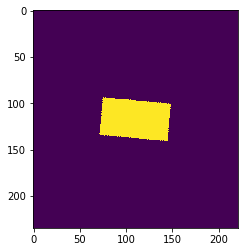

235 221 (235, 221, 2)
Box002
Box002_raster_cut.png
rotated image shape: (841, 902)
rotated iarray shape: (841, 902, 2)


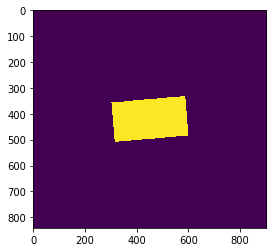

841 902 (841, 902, 2)
Box003
Box003_raster_cut.png
rotated image shape: (1087, 990)
rotated iarray shape: (1087, 990, 2)


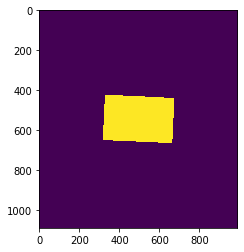

1087 990 (1087, 990, 2)
Box004
Box004_raster_cut.png
rotated image shape: (883, 952)
rotated iarray shape: (883, 952, 2)


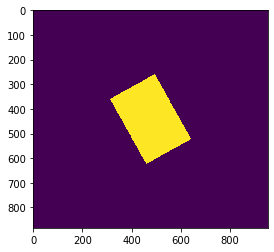

883 952 (883, 952, 2)
Box005
Box005_raster_cut.png
rotated image shape: (1405, 1571)
rotated iarray shape: (1405, 1571, 2)


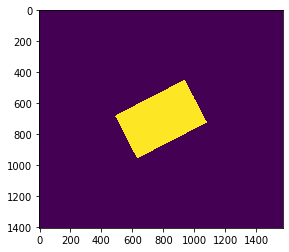

1405 1571 (1405, 1571, 2)
Box006
Box006_raster_cut.png
rotated image shape: (524, 483)
rotated iarray shape: (524, 483, 2)


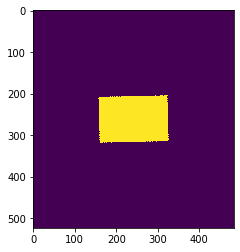

524 483 (524, 483, 2)
Box007
Box007_raster_cut.png
rotated image shape: (1201, 1289)
rotated iarray shape: (1201, 1289, 2)


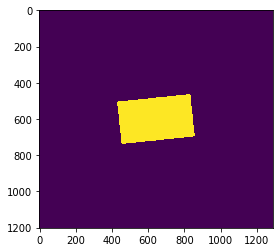

1201 1289 (1201, 1289, 2)
Box008
Box008_raster_cut.png
rotated image shape: (1878, 1922)
rotated iarray shape: (1878, 1922, 2)


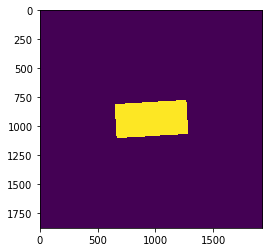

1878 1922 (1878, 1922, 2)
Box009
Box009_raster_cut.png
rotated image shape: (1275, 1261)
rotated iarray shape: (1275, 1261, 2)


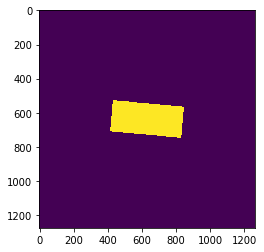

1275 1261 (1275, 1261, 2)
Box010
Box010_raster_cut.png
rotated image shape: (577, 629)
rotated iarray shape: (577, 629, 2)


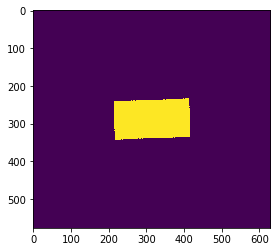

577 629 (577, 629, 2)
Box011
Box011_raster_cut.png
rotated image shape: (689, 647)
rotated iarray shape: (689, 647, 2)


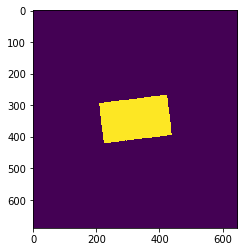

689 647 (689, 647, 2)
Box012
Box012_raster_cut.png
rotated image shape: (615, 648)
rotated iarray shape: (615, 648, 2)


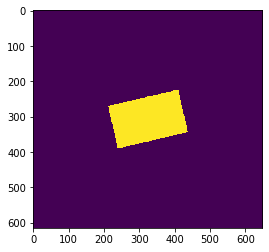

615 648 (615, 648, 2)
Box013
Box013_raster_cut.png
rotated image shape: (575, 561)
rotated iarray shape: (575, 561, 2)


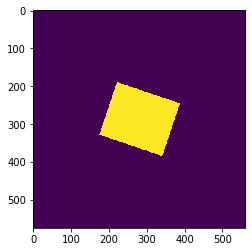

575 561 (575, 561, 2)
Box014
Box014_raster_cut.png
rotated image shape: (513, 518)
rotated iarray shape: (513, 518, 2)


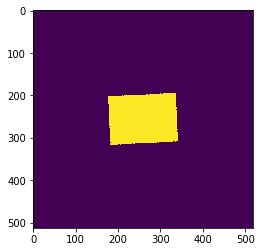

513 518 (513, 518, 2)
Box015
Box015_raster_cut.png
rotated image shape: (429, 449)
rotated iarray shape: (429, 449, 2)


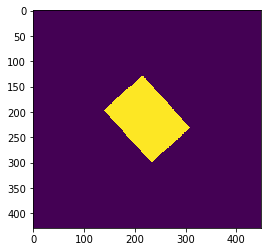

429 449 (429, 449, 2)
Box016
Box016_raster_cut.png
rotated image shape: (254, 287)
rotated iarray shape: (254, 287, 2)


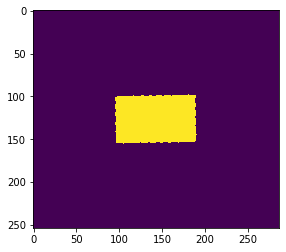

254 287 (254, 287, 2)
Box017
Box017_raster_cut.png
rotated image shape: (576, 535)
rotated iarray shape: (576, 535, 2)


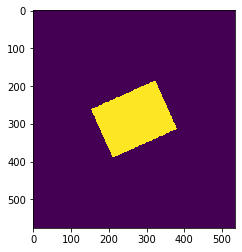

576 535 (576, 535, 2)
Box018
Box018_raster_cut.png
rotated image shape: (1033, 999)
rotated iarray shape: (1033, 999, 2)


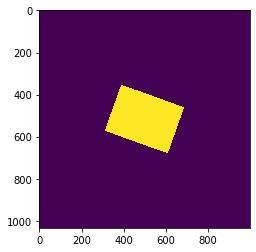

1033 999 (1033, 999, 2)
Box019
Box019_raster_cut.png
rotated image shape: (1566, 1566)
rotated iarray shape: (1566, 1566, 2)


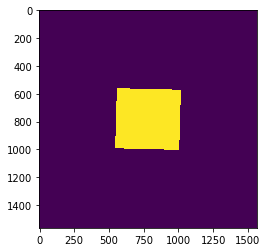

1566 1566 (1566, 1566, 2)
Box020
Box020_raster_cut.png
rotated image shape: (198, 253)
rotated iarray shape: (198, 253, 2)


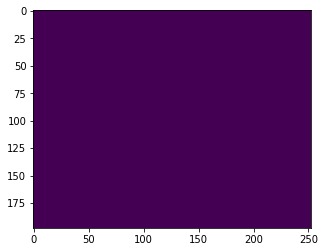

198 253 (198, 253, 2)
Box021
Box021_raster_cut.png
rotated image shape: (204, 196)
rotated iarray shape: (204, 196, 2)


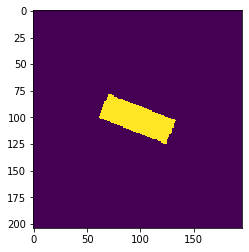

204 196 (204, 196, 2)
Box022
Box022_raster_cut.png
rotated image shape: (219, 183)
rotated iarray shape: (219, 183, 2)


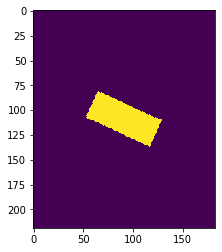

219 183 (219, 183, 2)
Box023
Box023_raster_cut.png
rotated image shape: (252, 198)
rotated iarray shape: (252, 198, 2)


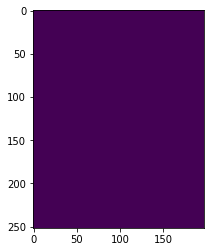

252 198 (252, 198, 2)
Box024
Box024_raster_cut.png
rotated image shape: (360, 354)
rotated iarray shape: (360, 354, 2)


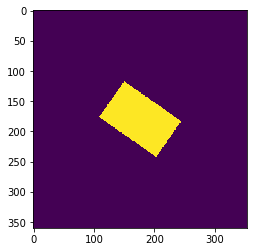

360 354 (360, 354, 2)
Box025
Box025_raster_cut.png
rotated image shape: (514, 513)
rotated iarray shape: (514, 513, 2)


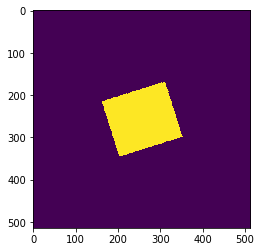

514 513 (514, 513, 2)
Box026
Box026_raster_cut.png
rotated image shape: (384, 400)
rotated iarray shape: (384, 400, 2)


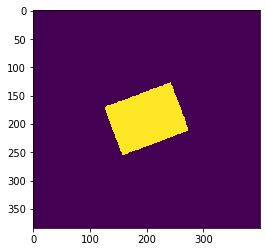

384 400 (384, 400, 2)
Box027
Box027_raster_cut.png
rotated image shape: (146, 174)
rotated iarray shape: (146, 174, 2)


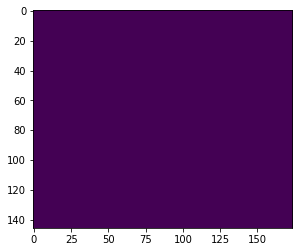

146 174 (146, 174, 2)
Box028
Box028_raster_cut.png
rotated image shape: (244, 231)
rotated iarray shape: (244, 231, 2)


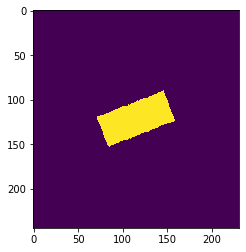

244 231 (244, 231, 2)
Box029
Box029_raster_cut.png
rotated image shape: (195, 196)
rotated iarray shape: (195, 196, 2)


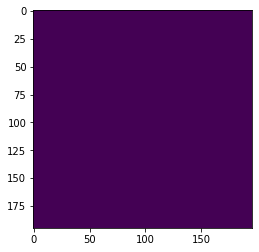

195 196 (195, 196, 2)
Box030
Box030_raster_cut.png
rotated image shape: (200, 190)
rotated iarray shape: (200, 190, 2)


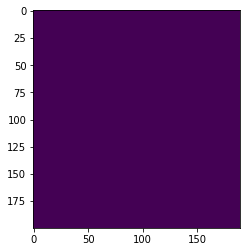

200 190 (200, 190, 2)
Box031
Box031_raster_cut.png
rotated image shape: (393, 381)
rotated iarray shape: (393, 381, 2)


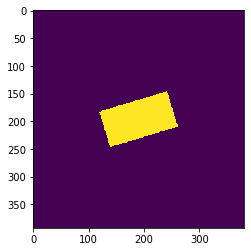

393 381 (393, 381, 2)
Box032
Box032_raster_cut.png
rotated image shape: (179, 170)
rotated iarray shape: (179, 170, 2)


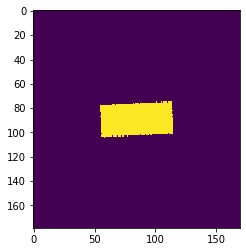

179 170 (179, 170, 2)
Box033
Box033_raster_cut.png
rotated image shape: (715, 739)
rotated iarray shape: (715, 739, 2)


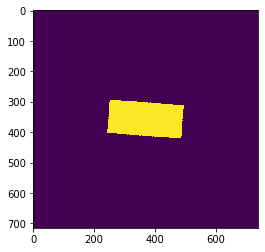

715 739 (715, 739, 2)
Box034
Box034_raster_cut.png
rotated image shape: (481, 457)
rotated iarray shape: (481, 457, 2)


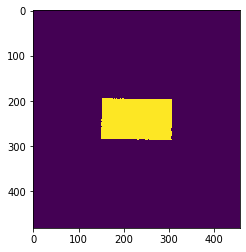

481 457 (481, 457, 2)
Box035
Box035_raster_cut.png
rotated image shape: (315, 330)
rotated iarray shape: (315, 330, 2)


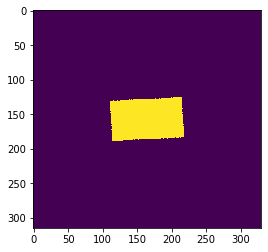

315 330 (315, 330, 2)
Box036
Box036_raster_cut.png
rotated image shape: (449, 422)
rotated iarray shape: (449, 422, 2)


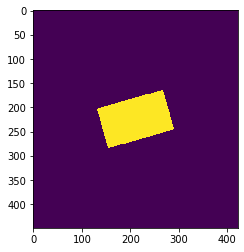

449 422 (449, 422, 2)
Box037
Box037_raster_cut.png
rotated image shape: (219, 211)
rotated iarray shape: (219, 211, 2)


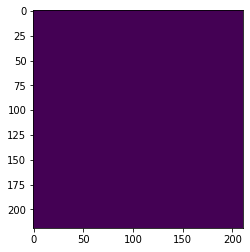

219 211 (219, 211, 2)
Box038
Box038_raster_cut.png
rotated image shape: (486, 434)
rotated iarray shape: (486, 434, 2)


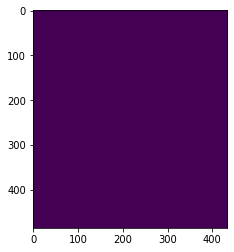

486 434 (486, 434, 2)
Box039
Box039_raster_cut.png
rotated image shape: (670, 618)
rotated iarray shape: (670, 618, 2)


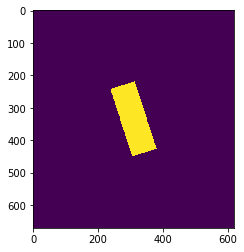

670 618 (670, 618, 2)
Box040
Box040_raster_cut.png
rotated image shape: (372, 367)
rotated iarray shape: (372, 367, 2)


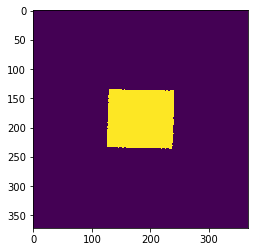

372 367 (372, 367, 2)
Box041
Box041_raster_cut.png
rotated image shape: (310, 279)
rotated iarray shape: (310, 279, 2)


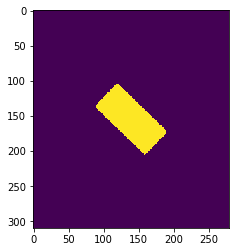

310 279 (310, 279, 2)
Box042
Box042_raster_cut.png
rotated image shape: (374, 365)
rotated iarray shape: (374, 365, 2)


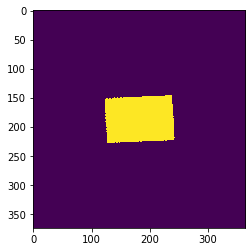

374 365 (374, 365, 2)
Box043
Box043_raster_cut.png
rotated image shape: (398, 398)
rotated iarray shape: (398, 398, 2)


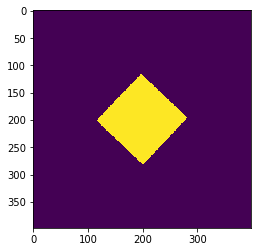

398 398 (398, 398, 2)
Box044
Box044_raster_cut.png
rotated image shape: (219, 238)
rotated iarray shape: (219, 238, 2)


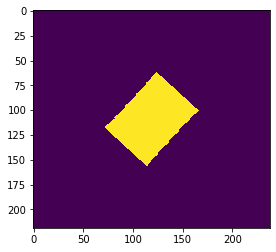

219 238 (219, 238, 2)
Box045
Box045_raster_cut.png
rotated image shape: (316, 335)
rotated iarray shape: (316, 335, 2)


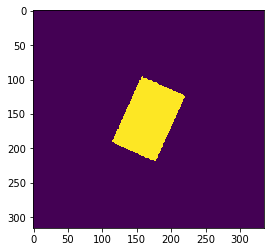

316 335 (316, 335, 2)
Box046
Box046_raster_cut.png
rotated image shape: (334, 289)
rotated iarray shape: (334, 289, 2)


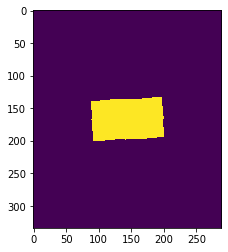

334 289 (334, 289, 2)
Box047
Box047_raster_cut.png
rotated image shape: (220, 241)
rotated iarray shape: (220, 241, 2)


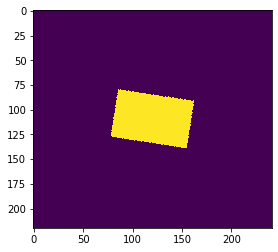

220 241 (220, 241, 2)
Box048
Box048_raster_cut.png
rotated image shape: (267, 247)
rotated iarray shape: (267, 247, 2)


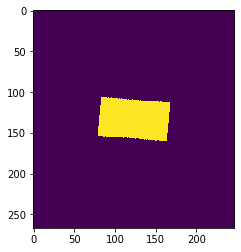

267 247 (267, 247, 2)
Box049
Box049_raster_cut.png
rotated image shape: (271, 309)
rotated iarray shape: (271, 309, 2)


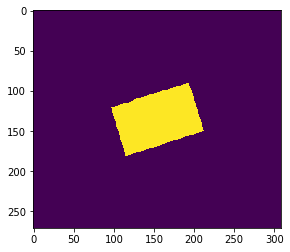

271 309 (271, 309, 2)
Box050
Box050_raster_cut.png
rotated image shape: (238, 220)
rotated iarray shape: (238, 220, 2)


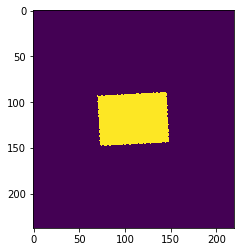

238 220 (238, 220, 2)


In [19]:
# rotate the images and resize them
for index, row in velocities_df.iterrows():
    BoxID = index; print("Box"+BoxID) # keep track of progress
    for file in os.listdir(downloadpath+"Box"+BoxID+'/reprojected/'):
        if file.endswith('raster_cut.png'):
            print(file)
            # grab the transform from the geotiff version
            gtiff = rio.open(downloadpath+"Box"+BoxID+'/reprojected/'+file[:-4]+'.TIF')
            [left,bottom,right,top] = gtiff.bounds # grab extent
            pixres = gtiff.transform[0] # grab pixel resolution [m]
            
            # open and rotate
            img  = Image.open(downloadpath+"Box"+BoxID+'/reprojected/'+file)
#             rotated = img.rotate(-float(row['Flow_dir']))
            rotated = rotate(img,angle=-float(row['Flow_dir']),reshape=False)
            rot_img = Image.fromarray(rotated)
            print('rotated image shape:', rotated.shape)
            
            # grab img coordinates too (grid center coords)
            xi, yi = np.meshgrid(np.arange(left+pixres/2,right,pixres),
                                 np.flip(np.arange(bottom+pixres/2,top,pixres)), # flip the y
                                 indexing='xy')
            iarray = np.dstack((xi,yi))
            if iarray.shape[:2] != rotated.shape: # if x y dimensions don't match,
                # try again
                xi, yi = np.meshgrid(np.arange(left+pixres/2,right-pixres/2,pixres),
                             np.flip(np.arange(bottom+pixres/2,top-pixres/2,pixres)), # flip the y
                             indexing='xy'); iarray = np.dstack((xi,yi))
            rot_iarray = rotate(iarray,angle=-float(row['Flow_dir']),reshape=False) # rotate the image coordinates
            
            print("rotated iarray shape:", rot_iarray.shape)
            
            # visualize rotated image
            plt.imshow(rotated)
            plt.show()
            
            # save
            rot_img.save(downloadpath+"Box"+BoxID+'/'+folder_name+'/R_'+file)
            
            
    resizepath = downloadpath+"Box"+BoxID+'/'+folder_name+'/' # path to rotated images
    orig_img_idxs = resize_pngs(resizepath,rot_iarray) # crop all and indices as well
    
    # save original image indexes (geographic coordinates)
    np.savetxt(resizepath+'img_xidx_Box'+BoxID+'.csv',orig_img_idxs[:,:,0]) # x
    np.savetxt(resizepath+'img_yidx_Box'+BoxID+'.csv',orig_img_idxs[:,:,1]) # y

# 5) Convert images to pgm for WTMM




In [14]:
# convert all final files to pgm
for index, row in velocities_df.iterrows():
    BoxID = index
#     command = 'cd '+downloadpath+'Box'+BoxID+'/'+folder_name+'/; magick mogrify -depth 16 -format pgm *.png' # Mac
    command = 'cd '+downloadpath+'Box'+BoxID+'/'+folder_name+'/; mogrify -depth 16 -format pgm *.png' # Linux
    subprocess.call(command, shell=True)

In [15]:
# remove intermediate pngs
for BoxID in BoxIDs:
    resizepath = downloadpath+"Box"+BoxID+'/'+folder_name+'/' # path to rotated & cropped images
    rp_path = downloadpath+"Box"+BoxID+'/reprojected/' # path to reprojected images
    for path in [resizepath, rp_path]: # remove pngs from both
        for png in os.listdir(path):
            if png.endswith('.png') and 'raster_cut' not in png: # remove all besides the rasterized box
                os.remove(path+png)